In [6]:
#imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
from PIL.Image import open
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from scikitplot.metrics import plot_roc_curve, roc_curve, auc
import torch.nn.functional as F

In [4]:
#feature loading
brainTumor = pd.read_csv('Brain Tumor.csv')
btDatasetT3 = pd.read_csv('bt_dataset_t3.csv')

In [5]:
#image loading
def image_loading(df):
    path_list = []
    base_path = os.path.join('.', 'Brain Tumor', 'Brain Tumor')
    #base_path = './Brain Tumor/Brain Tumor'
    for entry in os.listdir(base_path):
        path_list.append(os.path.join(base_path,entry))
    pathes_dict={os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
    df['pathes'] = df['Image'].map(pathes_dict.get)
    df['pixels']= df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))
    return df


def dataframe_to_Xy(df):
    image_list = []
    for i in range(0,len(df)):
        # load image
        brain_img = df['pixels'][i].astype(np.float32)
        img_array = image.img_to_array(brain_img)
         # append to list of all images
        image_list.append(keras.applications.mobilenet_v2.preprocess_input(img_array))

    # convert image list to single array
    # Our feature
    X = np.array(image_list)
    y = np.array(df.Class)
    return X,y

brainTumor = image_loading(brainTumor)
X_image, y = dataframe_to_Xy(brainTumor)
feature_list = [i for i in brainTumor.columns if i not in ['pathes', 'pixels', 'Image', 'Class']]
X_feature = brainTumor[feature_list].to_numpy()

In [6]:
'''train val test split - I will split the data to 80% 20% 20% (train val test) both features and images (with same
indexs to compare results) '''
#path_list
train_index, test_index = train_test_split(np.arange(len(X_image)), test_size=0.2, random_state=0)
train_index, val_index = train_test_split(train_index, test_size=0.25, random_state=0)
X_image_train, X_image_val, X_image_test = X_image[train_index], X_image[val_index], X_image[test_index]
X_feature_train, X_feature_val, X_feature_test = X_feature[train_index], X_feature[val_index], X_feature[test_index]
y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]
print('The shape of the X_image_train :'+' '+str(X_image_train.shape))
print('The shape of the X_feature_train :'+' '+str(X_feature_train.shape))

The shape of the X_image_train : (2256, 224, 224, 3)
The shape of the X_feature_train : (2256, 13)


C:\Users\USER\Anaconda3\envs\scorch\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


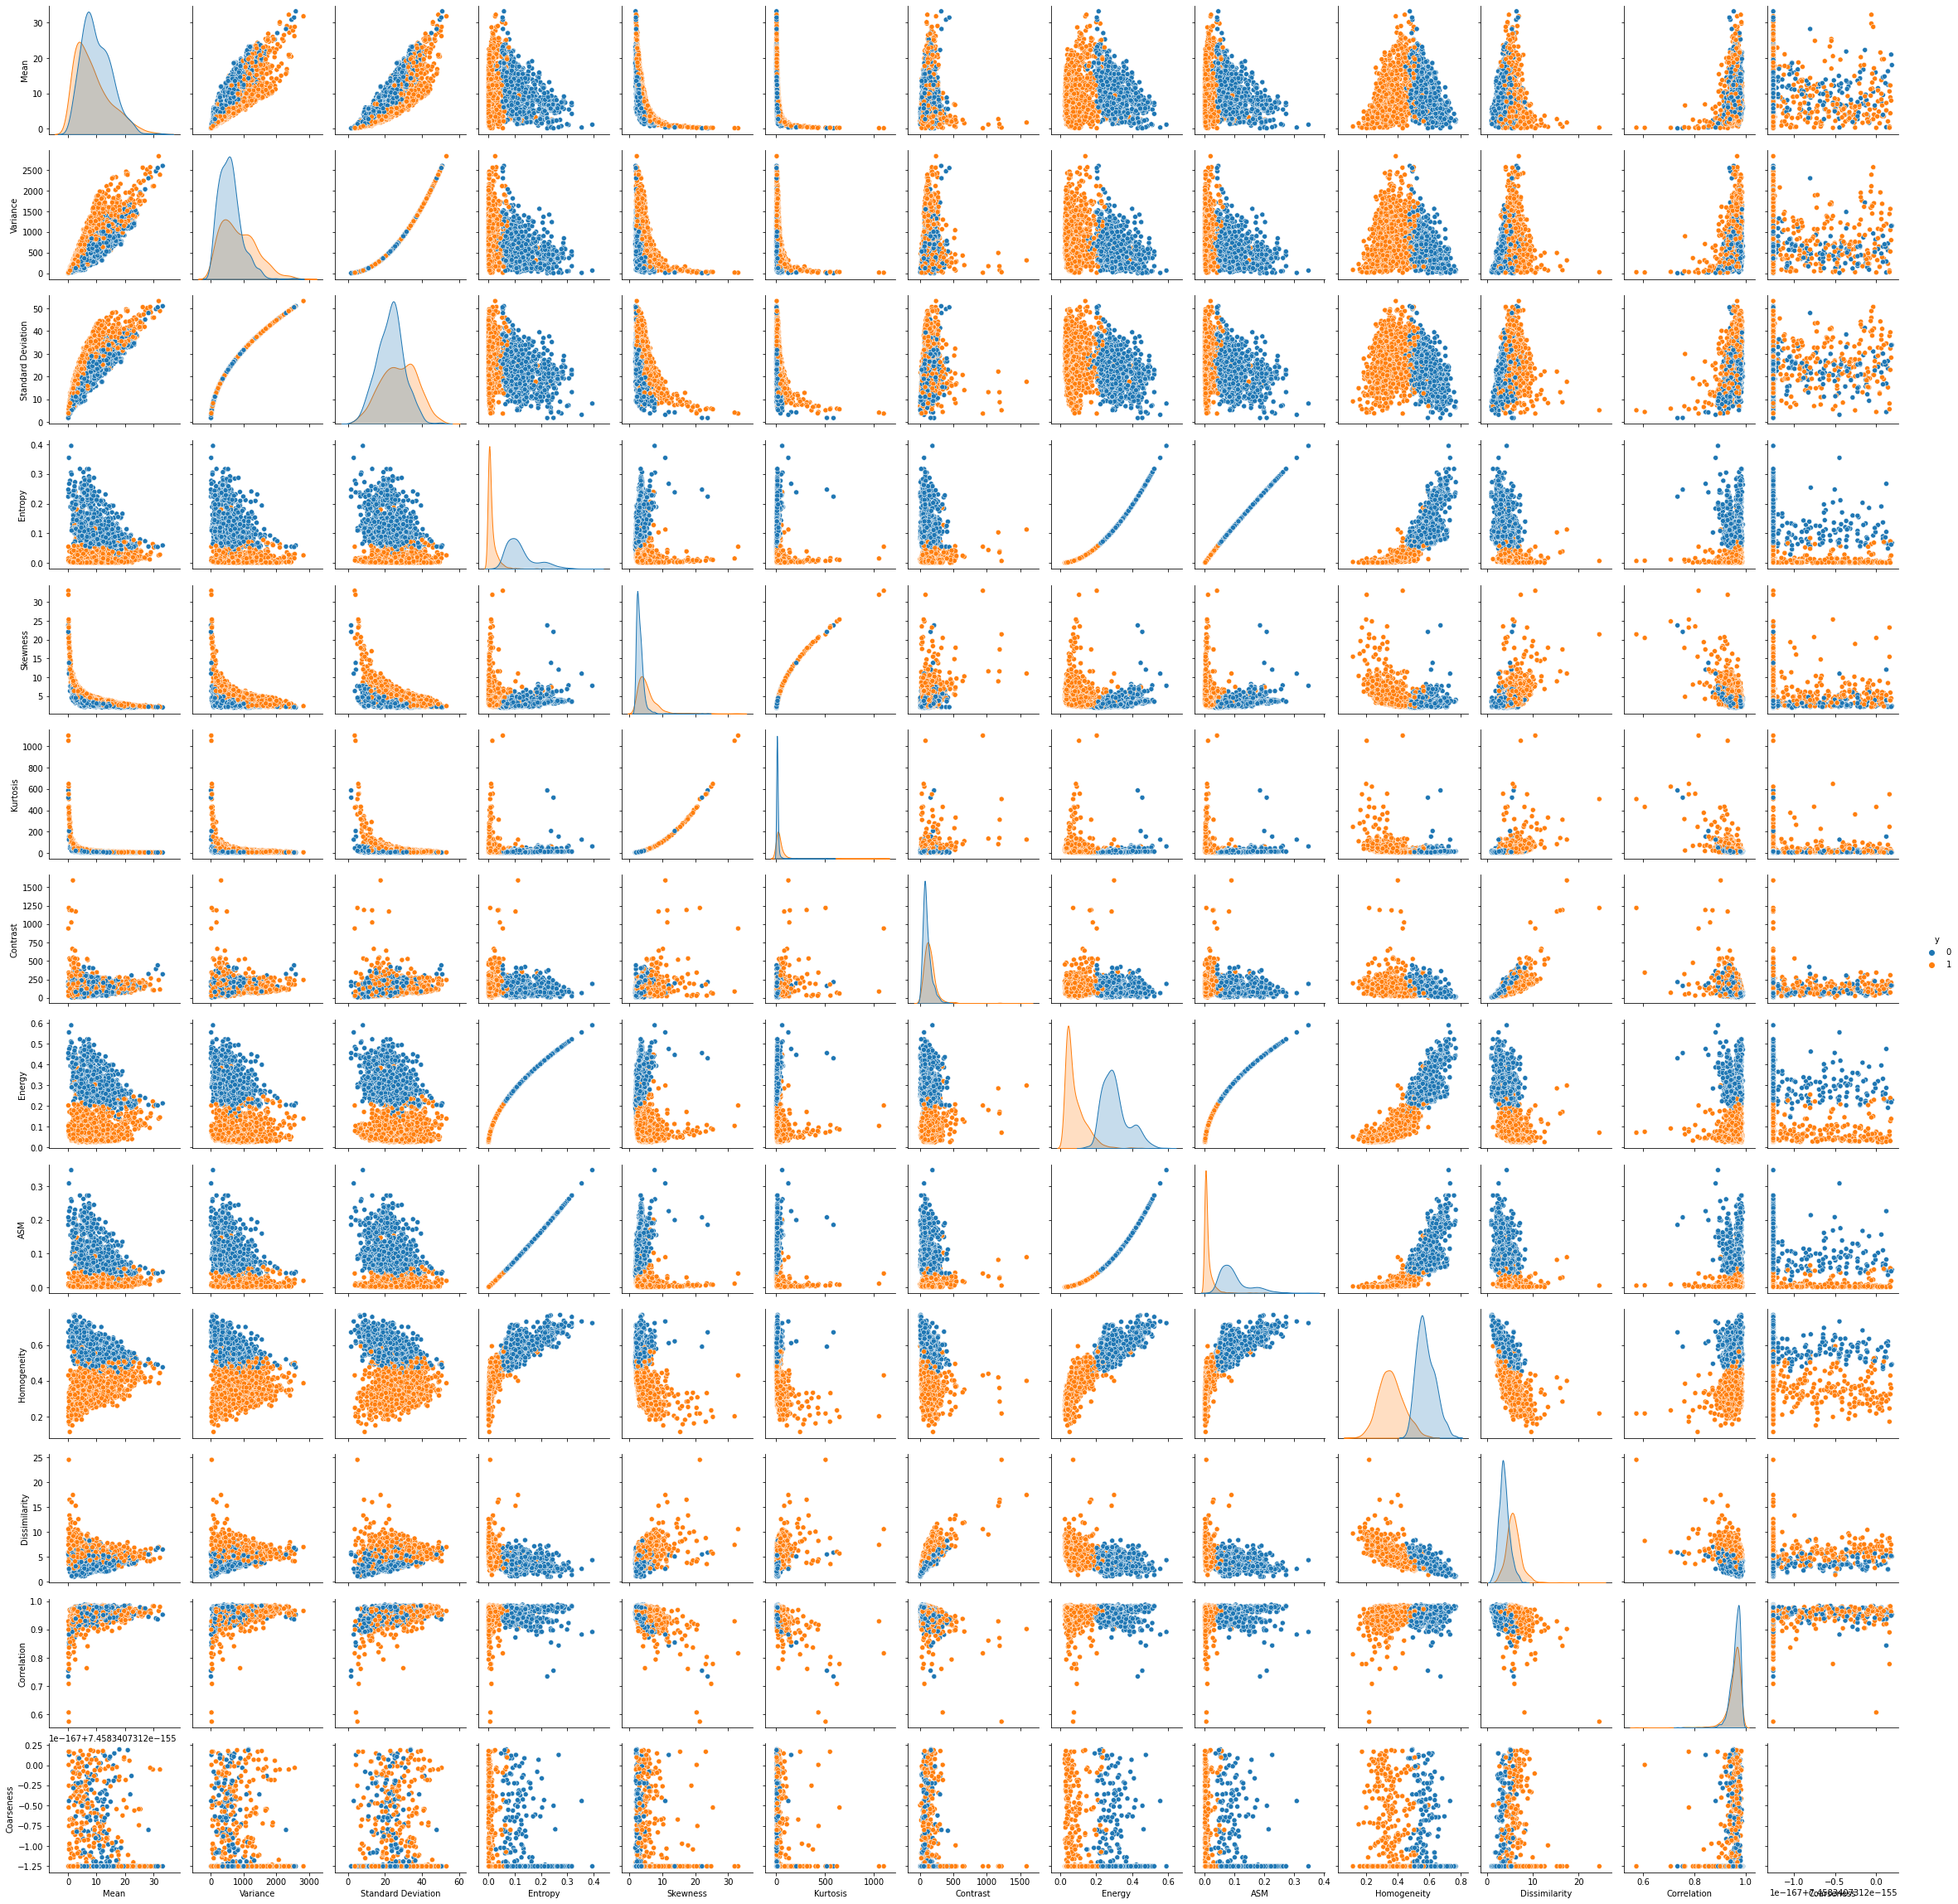

In [7]:
#data 
df_train = pd.DataFrame(X_feature_train, columns = feature_list)
df_train['y'] = y_train
sns.pairplot(df_train, hue='y')

<AxesSubplot:xlabel='Class'>

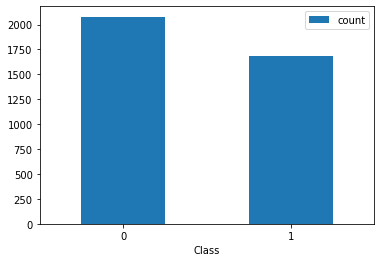

In [8]:
#0/1 Class proportion (are we have inblance dataset?)
df_group = brainTumor.groupby('Class')['pathes'].count().reset_index()
df_group.columns = ['Class', 'count']
df_group.plot.bar(x='Class', y='count', rot=0)
#blanced dataset +-

As we can see some feature has a real potentional to seperate the data well.
we will try to train some models and compare them (only with train and val set).
first normalise the data with z_score and then use some feature selections methods.

In [9]:
#normalisation
scale = StandardScaler()
scale.fit(X_feature_train)
X_feature_train = scale.fit_transform(X_feature_train)
X_feature_val = scale.fit_transform(X_feature_val)
X_feature_test = scale.fit_transform(X_feature_test)

In [10]:
#feature selections
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_feature_train, y_train)
print('no selection train accuracy', round(accuracy_score(clf.predict(X_feature_train), y_train),2))
print('no selection val accuracy', round(accuracy_score(clf.predict(X_feature_val), y_val),2))
#lets take the 5 most important and see the differance
features_5 = [x[0] for x in sorted(zip(feature_list, clf.feature_importances_), key = lambda x: -x[1])][:5]
features_10 = [x[0] for x  in sorted(zip(feature_list, clf.feature_importances_), key = lambda x: -x[1])][:10]
binary_features_5 = [i in features_5 for i in feature_list]
binary_features_10 = [i in features_10 for i in feature_list]
clf10 = RandomForestClassifier(max_depth=2, random_state=0)
clf10.fit(X_feature_train[:, binary_features_10], y_train)
print('10 selection train accuracy', round(accuracy_score(clf10.predict(X_feature_train[:, binary_features_10]), y_train),2))
print('10 selection val accuracy', round(accuracy_score(clf10.predict(X_feature_val[:, binary_features_10]), y_val),2))
clf5 = RandomForestClassifier(max_depth=2, random_state=0)
clf5.fit(X_feature_train[:, binary_features_5], y_train)
print('5 selection train accuracy', round(accuracy_score(clf5.predict(X_feature_train[:, binary_features_5]), y_train),2))
print('5 selection val accuracy', round(accuracy_score(clf5.predict(X_feature_val[:, binary_features_5]), y_val),2))


no selection train accuracy 0.98
no selection val accuracy 0.99
10 selection train accuracy 0.98
10 selection val accuracy 0.98
5 selection train accuracy 0.98
5 selection val accuracy 0.99


no selection train accuracy 0.98
no selection val accuracy 0.99
val auc score 0.9970576022680088


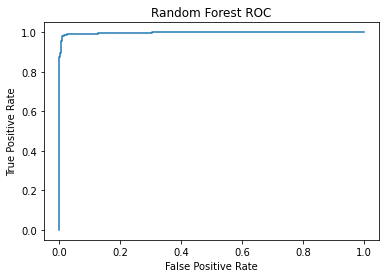

In [54]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_feature_train, y_train)
print('no selection train accuracy', round(accuracy_score(clf.predict(X_feature_train), y_train),2))
print('no selection val accuracy', round(accuracy_score(clf.predict(X_feature_val), y_val),2))
pred_val_RF = clf.predict_proba(X_feature_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, pred_val_RF)
print('val auc score', auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.title('Random Forest ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The results look a little bit fishy, to good to be true...
On the one hand the kaggle 'author' said that does features are just statistically calculated from the data.
On the other hand it was too easy so I think they might calculate it with 'Class' column.
With infinite time I would try to reproduce the feature results, but Im short on schedule...
But It's open us to other option...
Let's do some unsupervised learning (with AE, n_latent = number of features)... and see if we can correlation between them (and mabye see the differnce in Classifing with random forest as well)

In [42]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [43]:
class UnFlatten(nn.Module):
    def forward(self, input, size=36864):
        return input.view(input.size(0), 4, 56, 56)

In [44]:
#AE
class ConvAutoencoder(nn.Module):
    def __init__(self, z_dim = 13, h_dim=4*56*56):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )
    def encode(self, x):
        h = self.encoder(x)
        z = self.fc1(h)
        return z
    def decode(self, z):
        z = self.fc2(z)
        z = self.decoder(z)
        return z
    def forward(self, x):
        z = self.encode(x)
        z = self.decode(z)
        return z
model = ConvAutoencoder()
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
model.to(device)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten()
  )
  (fc1): Linear(in_features=12544, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=12544, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (4): Sigmoid()
  )
)

In [46]:
#Epochs
n = len(X_image_train)
n_epochs = 10
batch_size = 8
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    for idx in range(0, len(X_image_train), batch_size):
        images = torch.Tensor(X_image_train[idx:idx+batch_size].reshape(-1,3,224,224)).to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss / n
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: -14.702153
Epoch: 2 	Training Loss: -20.760886
Epoch: 3 	Training Loss: -20.762909
Epoch: 4 	Training Loss: -20.769957
Epoch: 5 	Training Loss: -20.780133
Epoch: 6 	Training Loss: -20.795183
Epoch: 7 	Training Loss: -20.815137
Epoch: 8 	Training Loss: -20.896274
Epoch: 9 	Training Loss: -21.123491
Epoch: 10 	Training Loss: -21.167686


In [47]:
def get_ae_features(X):
    for idx in range(0, len(X), batch_size):
        if idx == 0:
            images = torch.Tensor(X[idx:idx+batch_size].reshape(-1,3,224,224)).to(device)
            features= model.encode(images)
            features = features.detach().cpu().numpy()
        else:
            images = torch.Tensor(X[idx:idx+batch_size].reshape(-1,3,224,224)).to(device)
            features1 = model.encode(images)        
            features = np.concatenate([features, features1.detach().cpu().numpy()])
    return features

In [48]:
X_ae_train = get_ae_features(X_image_train)
X_ae_val = get_ae_features(X_image_val)
scale = StandardScaler()
scale.fit(X_ae_train)
X_ae_train = scale.fit_transform(X_ae_train)
X_ae_val = scale.fit_transform(X_ae_val)


train accuracy 0.73
val accuracy 0.73
val auc score 0.316075084835555


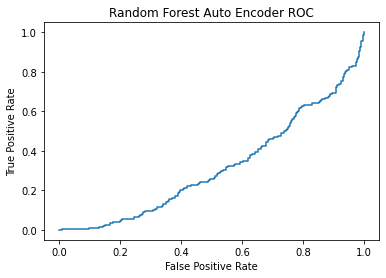

In [55]:
clf_ae = RandomForestClassifier(max_depth=2, random_state=0)
clf_ae.fit(X_ae_train, y_train)
print('train accuracy', round(accuracy_score(clf_ae.predict(X_ae_train), y_train),2))
print('val accuracy', round(accuracy_score(clf_ae.predict(X_ae_val), y_val),2))
pred_val_RF_ae = clf_ae.predict_proba(X_feature_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, pred_val_RF_ae)
print('val auc score', auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.title('Random Forest Auto Encoder ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see the auto encoder doesnt work well as the original feature one...
If I had more time to the project I would do several steps in this filed
1. try optimize the AE - I dont have a lot of expirence in this subject. I would try to explore different network archictures and hyper parameters.
2. try to reproduce the feature from images (from the article I refer). It can some time because of potensioal hyper parameters.


In the bottom line, if a code for feature extraction been added to the dataset it would make our life a lot better.
Documentation is a major problem in the data science world...

now I will try to find a CNN network classification. We will run some different architectures with different hyper parameters and compare there ROC curve and AUC score.

In [58]:
#only image classification(CNN)
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(4*56*56, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.cnn(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [59]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(4*56*56, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.cnn(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [60]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            Flatten()
        )
        self.fc1 = nn.Linear(4*56*56, 32)
        self.fc2 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.cnn(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [62]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [63]:
n = len(X_image_train)
n_epochs = 3
epochs_list = range(1, n_epochs+1)
criterion = nn.BCELoss()

In [64]:
def cnn_optimization(cnn):
    learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
    batch_sizes = [8, 16, 32]
    min_loss = 1000
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            try_model, model_loss = run_cnn(cnn, learning_rate, batch_size)
            if np.min(model_loss) < min_loss:
                min_loss = np.min(model_loss)
                lr = learning_rate
                bc = batch_size
                best_model = try_model
    print('optimal variables are ... ')
    print('learning rate - ', lr, 'batch size - ', bc)
    return best_model, bc

In [65]:
def run_cnn(cnn, learning_rate, batch_size):
    model = cnn()
    device = get_device()
    model.to(device)
    model_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in epochs_list:
        train_loss = 0.0
        for idx in range(0, len(X_image_train), batch_size):
            images = torch.Tensor(X_image_train[idx:idx+batch_size].reshape(-1,3,224,224)).to(device)
            outputs = model(images)
            loss = criterion(outputs, torch.Tensor(y_train[idx:idx+batch_size]).to(device).reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
        model_loss.append(train_loss / n)
    return model, model_loss

In [66]:
def get_y(model, X, batch_size):
    for idx in range(0, len(X), batch_size):
        if idx == 0:
            images = torch.Tensor(X[idx:idx+batch_size].reshape(-1,3,224,224)).to(device)
            y = model(images)
            y = y.detach().cpu().numpy()
        else:
            images = torch.Tensor(X[idx:idx+batch_size].reshape(-1,3,224,224)).to(device)
            y1 = model(images)        
            y = np.concatenate([y, y1.detach().cpu().numpy()])
    return y

In [67]:
best_cnn1, batch_size1 = cnn_optimization(CNN1)

C:\Users\USER\Anaconda3\envs\scorch\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


optimal variables are ... 
learning rate -  0.0005 batch size -  8


In [68]:
best_cnn2, batch_size2 = cnn_optimization(CNN2)

optimal variables are ... 
learning rate -  0.001 batch size -  8


In [69]:
best_cnn3, batch_size3 = cnn_optimization(CNN3)

optimal variables are ... 
learning rate -  0.005 batch size -  8


C:\Users\USER\Anaconda3\envs\scorch\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


cnn1 val auc score 0.9579688148795119
cnn2 val auc score 0.9774774129809138
cnn3 val auc score 0.9718575049039962


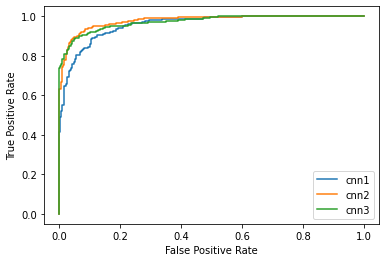

In [76]:
pred_val_cnn1 = get_y(best_cnn1, X_image_val, batch_size1)
pred_val_cnn2 = get_y(best_cnn2, X_image_val, batch_size2)
pred_val_cnn3 = get_y(best_cnn3, X_image_val, batch_size3)

fpr_cnn1, tpr_cnn1, thresholds = roc_curve(y_val, pred_val_cnn1)
plt.plot(fpr_cnn1, tpr_cnn1, label='cnn1')
print('cnn1 val auc score', auc(fpr_cnn1, tpr_cnn1))
fpr_cnn2, tpr_cnn2, thresholds = roc_curve(y_val, pred_val_cnn2)
plt.plot(fpr_cnn2, tpr_cnn2, label='cnn2')
print('cnn2 val auc score', auc(fpr_cnn2, tpr_cnn2))
fpr_cnn3, tpr_cnn3, thresholds = roc_curve(y_val, pred_val_cnn3)
plt.plot(fpr_cnn3, tpr_cnn3, label='cnn3')
print('cnn3 val auc score', auc(fpr_cnn3, tpr_cnn3))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

now we will compare between the best cnn network, random forest on AE and random forest on features in the same graph for smath analysis

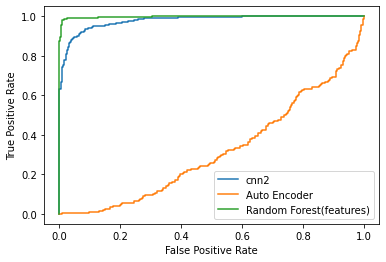

In [80]:
#best model. including ROC analysis and human ״Performance analysis"
fpr_cnn2, tpr_cnn2, thresholds = roc_curve(y_val, pred_val_cnn2)
plt.plot(fpr_cnn2, tpr_cnn2, label='cnn2')
pred_val_RF_ae = clf_ae.predict_proba(X_feature_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, pred_val_RF_ae)
plt.plot(fpr, tpr, label='Auto Encoder')
pred_val_RF = clf.predict_proba(X_feature_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, pred_val_RF)
plt.plot(fpr, tpr, label='Random Forest(features)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

C:\Users\USER\Anaconda3\envs\scorch\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


cnn2 val auc score 0.9825212464589235


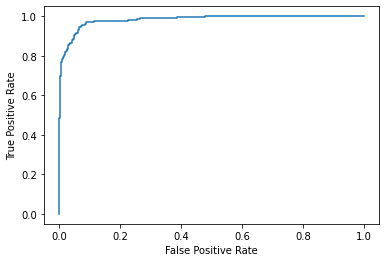

In [93]:
#test set on cnn2
pred_test_cnn2 = get_y(best_cnn2, X_image_test, batch_size2)
fpr_cnn2, tpr_cnn2, thresholds = roc_curve(y_test, pred_test_cnn2)
plt.plot(fpr_cnn2, tpr_cnn2, label='cnn2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('cnn2 val auc score', auc(fpr_cnn2, tpr_cnn2))

Originally I wanna see the vanrabilion of our network to Adverserial examples attacks. and then compare it to the AE/feature model.
but
1. could get the features like in the dataset... so I cant attack a image and extact the features from it
2. our AE model is very bad
so we will just explore Adverserial example and how it can affect a well trained CNN

In [94]:
#resistance over advarserial exmaples
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [105]:
epsilons = [.05, .1, .15, .2, .25, .3, .35, .4]

In [106]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [107]:
def test(model, device, X_val, y_val, epsilon, test_val):

    # Accuracy counter
    correct = 0
    adv_examples = []
    n_val = len(X_val)
    # Loop over all examples in test set
    for i in range(n_val):
        # Send the data and label to the device
        data = torch.Tensor(X_val[i].reshape(-1,3,224,224)).to(device)
        target = torch.Tensor([y_val[i]]).to(device)
        data.requires_grad = True
        # Set requires_grad attribute of tensor. Important for Attack
        

        # Forward pass the data through the model
        output = model(data)        
        init_pred = 1 if (output.item() > 0.5) else 0 
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred != target.item():
            continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        #final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred =  1 if (output.item() > 0.5) else 0 
        if final_pred == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred, final_pred, adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred, final_pred, adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(n_val)
    print("Epsilon: {}\t{} = {} / {} = {}".format(epsilon, test_val,correct, n_val, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [108]:
for eps in epsilons:
    acc, ex = test(best_cnn1, device, X_image_val, y_val, eps, 'Val Accuracy')

Epsilon: 0.05	Val Accuracy = 339 / 753 = 0.450199203187251
Epsilon: 0.1	Val Accuracy = 337 / 753 = 0.44754316069057104
Epsilon: 0.15	Val Accuracy = 336 / 753 = 0.44621513944223107
Epsilon: 0.2	Val Accuracy = 333 / 753 = 0.44223107569721115
Epsilon: 0.25	Val Accuracy = 312 / 753 = 0.41434262948207173
Epsilon: 0.3	Val Accuracy = 274 / 753 = 0.36387782204515273
Epsilon: 0.35	Val Accuracy = 240 / 753 = 0.3187250996015936
Epsilon: 0.4	Val Accuracy = 215 / 753 = 0.2855245683930943
